## Data Analyser and stock retriver
Lets get the necessary packages down

In [10]:
import yfinance as yf
import matplotlib.pyplot as plt
import scipy as sc
import pandas as pd
import selenium as slc ### Unused
from datetime import datetime, timedelta
import ipywidgets as widgets
from IPython.display import display
import warnings
warnings.filterwarnings("ignore")

### if you don't already have the packages u can run this

In [ ]:
!pip install pandas sqlalchemy matplotlib ipywidgets

### Generating tickers and storing them
`generate_ticker` will receive the date start, date end, interval and ticker name to populate yfinance data
1. If no ticker name is specified, it will return SP500 index
2. It does not filter non-trading days data, yfinance ignores it anyways
3. Look at the comment below to be informed of the output format, it returns a tuple containing the dataframe and ticker name

In [7]:
### DOCUMENTATION FOR DOWNLOAD TICKER
### d_start, d_end date documentation "yyyy-mm-dd" 
### intervals "1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h,1d, 5d, 1wk, 1mo, 3mo"             
### ticker_array Type acceptable: List, Dict.keys(), Tuple

def generate_ticker(d_start, d_end, interval, ticker="SPY"):
    d_start = pd.to_datetime(d_start)
    d_end = pd.to_datetime(d_end)
    df = pd.DataFrame()
    
    while d_start < d_end:
        next_day = d_start + timedelta(days=1)
        stock_data = yf.download(ticker, start=d_start.strftime('%Y-%m-%d'), 
                                 end=next_day.strftime('%Y-%m-%d'), interval=interval)
    
        df = pd.concat([df, stock_data], ignore_index=False)
        
        d_start = next_day

    df = df.reset_index() 
    df.rename(columns={'index': 'Date'}, inplace=True)
    return (df,ticker)


### output: (ticker_dataframe, name)

### Functions below for dynamic storage
`create_data_keeper_class` is a helper function that stores the table uniquely by table_name

`keep_it_now` Works as the core data storage function. Ensure you have the database created, the creation happens in the cell after the cell below.

**DO NOTE SOME OF THE NAMES I CREATED WAS ALREADY NAMED** `Data.db` **SO ADJUST ACCORDINGLY**

In [5]:
from sqlalchemy import create_engine, Column, Integer, String, Float, Date, text, inspect, Table, MetaData,Table
from sqlalchemy.orm import sessionmaker, declarative_base
from datetime import datetime

Base = declarative_base()
# Function to create a dynamic DataKeeper class with a custom table name
def create_data_keeper_class(table_name):
    # Dynamically create a class with the given table name "table_name"
    return type(
        table_name, 
        (Base,), 
        {
            '__tablename__': table_name,
            'id': Column(Integer, primary_key=True),
            'name': Column(String),
            'date': Column(Date),
            'high': Column(Float),
            'low': Column(Float),
            'close': Column(Float),
            'adj_close': Column(Float),
            'volume': Column(Float),
        }
    )

# Function to add data to the database
def keep_it_now(ticker, session):
    values, name = ticker
    # Create a DataKeeper class dynamically with the name as the table name
    DataKeeper = create_data_keeper_class(name)

    # Ensure the ticker table is created in the database, for simplicity sake, it will be Data.db 
    Base.metadata.create_all(session.bind)

    for _, data in values.iterrows():
        try:
            # Convert date string to date object
            date = pd.to_datetime(data['Date']).date()
            close = float(data['Close'])
            adj_close = float(data['Adj Close'])
            low = float(data['Low'])
            high = float(data['High'])
            volume = float(data['Volume'])

            # Create an instance of DataKeeper with the extracted data
            data_entry = DataKeeper(
                name=name,
                date=date,
                close=close,
                adj_close=adj_close,
                volume=volume,
                high=high,
                low=low
            )
            session.add(data_entry)

        except Exception as e:
            print(f"Error processing row: {e}")

    try:
        session.commit()
        print(f"Data for {name} added to the database successfully.")
    except Exception as e:
        session.rollback()
        print(f"Error committing data to the database: {e}")



### Creating database SQLite
Only use the cell to create a new SQLite Engine, Current file: `Data`

In [ ]:
### Only use this to create a new SQLite engine
name = input("Choose a name for base:")
engine = create_engine(f"sqlite:///{name}.db")

### Adding all your interested tickers in
Use the widgets here to collect the ticker names before adding it to your SQLite database.

Anyways, this all isnt necessary, but If you have your own tickers keep it in a `list` with `str` format, and name the variable `tickers`

Additionally, `Ipywidgets` has become incompatible with newer versions of Jupyter Notebook

In [6]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Initialize list to store tickers, please use the same name tickers
tickers = []

# Function to add new input fields for tickers
def add_ticker_field(_):
    # Create a new text input widget
    ticker_input = widgets.Text(placeholder='Enter ticker', description='Ticker:')
    ticker_box.children = list(ticker_box.children) + [ticker_input]

# Function to handle the stop button click event
def stop_adding(_):
    # Gather all ticker inputs from the fields
    tickers.clear()  # Clear the list before collecting inputs
    for field in ticker_box.children:
        if isinstance(field, widgets.Text) and field.value:
            tickers.append(field.value)
    
    # Display the collected tickers
    clear_output(wait=True)
    print("Tickers collected:", tickers)

# Function to reset/clear all input fields
def reset_fields(_):
    tickers.clear()
    ticker_box.children = []
    
# Create the Add, Stop, and Reset buttons
add_button = widgets.Button(description="Add Ticker")
stop_button = widgets.Button(description="Stop")
reset_button = widgets.Button(description="Reset")

# Assign functions to button click events
add_button.on_click(add_ticker_field)
stop_button.on_click(stop_adding)
reset_button.on_click(reset_fields)
# Create a VBox to hold ticker input fields

ticker_box = widgets.VBox([])
# Display the interface
display(add_button, stop_button, reset_button, ticker_box)

### Validity of input
Assisting functions that validate data and help us to keep the data for later usage

In [2]:
import os
def isvalid_date(date_string):
    try:
        datetime.strptime(date_string, '%Y-%m-%d')
        return True
    except ValueError:
        return False
        
def isvalid_start_date(start_date, end_date):
    # Check if both dates are in the correct format
    if not isvalid_date(start_date) or not isvalid_date(end_date):
        return False
    
    start_date_obj = datetime.strptime(start_date, '%Y-%m-%d')
    end_date_obj = datetime.strptime(end_date, '%Y-%m-%d')
    today = datetime.now().date()
    
    # Check if start date is before today and one day before end date
    return start_date_obj.date() < today and start_date_obj + timedelta(days=1) <= end_date_obj
    
def isvalid_end_date(start_date, end_date):
    # Check if both dates are in the correct format
    if not isvalid_date(start_date) or not isvalid_date(end_date):
        return False
    
    start_date_obj = datetime.strptime(start_date, '%Y-%m-%d')
    end_date_obj = datetime.strptime(end_date, '%Y-%m-%d')
    today = datetime.now().date()
    
    # Check if end date is before today and one day after start date
    return end_date_obj.date() < today and end_date_obj >= start_date_obj + timedelta(days=1)

def valid_interval(interval):
    valid_intervals = ["1m", "2m", "5m", "15m", "30m", "60m", "90m", "1h", "1d", "5d", "1wk", "1mo", "3mo"]
    return interval in valid_intervals

def validate_engine_in_directory(engine_name):
    n = engine_name +".db"
    db_path = os.path.join(os.getcwd(), n)
    
    # Check if the file exists at the specified path
    return os.path.isfile(db_path)

# uncomment this if u wanna use it
'''tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'BRK.B', 'NVDA', 'JNJ', 'JPM', 'V',
           'UNH', 'PG', 'HD', 'MA', 'XOM', 'BAC', 'KO', 'PFE', 'DIS', 'CSCO', 'PEP',
           'LLY', 'MRK', 'ABBV', 'AVGO', 'TMO', 'ADBE', 'CMCSA', 'ACN', 'CVX', 'NFLX',
           'ORCL', 'ABT', 'VZ', 'WMT', 'INTC', 'MDT', 'DHR', 'NEE', 'MCD', 'NKE',
           'TXN', 'PYPL', 'LIN', 'CRM', 'QCOM', 'UPS', 'HON', 'BMY', 'RTX', 'AMGN',
           'UNP', 'LOW', 'T', 'PM', 'SPGI', 'IBM', 'MMM', 'CAT', 'AXP', 'ISRG',
           'BLK', 'ZTS', 'BKNG', 'GILD', 'DE', 'LMT', 'COST', 'CVS', 'GS', 'RTX',
           'SBUX', 'MO', 'GE', 'AMT', 'PLD', 'USB', 'SCHW', 'TGT', 'CHTR', 'MS',]'''

### Complete data Storage
Run the functions below that takes our collected ticker names and then locally store them in Data.db, note we reference tickers by `ticker_name` meaning each table is a ticker name in Data.db

Here are all the required inputs

1. start date
2. end date
3. interval
4. Database name (Exclusive of file type aka .db) !!! ensure database initialised otherwise nothing happens

In [ ]:
# Ensure that the tickers are alr stored in the previous widgets colleting the ticker data, otherwise error will occur
from sqlalchemy import create_engine, Column, Integer, String, Float, Date, text, inspect, Table, MetaData,inspect,Table
from sqlalchemy.orm import sessionmaker, declarative_base
import os
from datetime import datetime, timedelta
import pandas as pd

# Validate start to end date before registering ticker hsitoric data
while True:
    start_date = input("Enter start date (yyyy-mm-dd): ")
    end_date = input("Enter end date (yyyy-mm-dd): ")
    
    if isvalid_start_date(start_date, end_date) and isvalid_end_date(start_date, end_date):
        print("Both dates are valid.")
        break
    else:
        print("Invalid dates. Start date must be one day before end date, and both must be before today. Try again.")
        
# Validate the interval
while True:
    interval = input("interval:")
    if valid_interval(interval):
        break
    else:
        print("invalid interval, try again")
        
# Choosing the egnine
while True:
    engine_name = input("engine name:")
    if validate_engine_in_directory(engine_name):
        break
        
engine = create_engine(f'sqlite:///{engine_name}.db')
Session = sessionmaker(bind=engine)
session = Session()
Base.metadata.create_all(engine)
for ticker in tickers:
    data = generate_ticker(start_date,end_date,interval,ticker=ticker)
    keep_it_now(data,session)
session.close()

### Verifying and inspecting data
Query and view database data in a DataFrame

In [12]:
from sqlalchemy.orm import sessionmaker, declarative_base
from sqlalchemy import MetaData, create_engine, Table, select
import pandas as pd

def Get_data(engine_name,ticker):
    engine = create_engine(f'sqlite:///{engine_name}.db')
    
    # Reflect the metadata to access all tables
    metadata.reflect(bind=engine)

    # Set up the session
    Session = sessionmaker(bind=engine)
    session = Session()

    
    # Check if the table exists in the database
    if ticker in metadata.tables:
        # Dynamically get the table using the table name
        table = Table(ticker, metadata, autoload_with=engine)

        # Create a query to select all data from the table
        query = select(table).limit(10000)

        # Execute the query and fetch results
        result = session.execute(query)

        # Iterate through the result and print each row
        X = pd.DataFrame(result)

    else:
        return print(f"Table '{table_name}' not found in the database.")
    return X

# Create a MetaData instance to reflect the database
metadata = MetaData()

while True:
    engine_name = input("engine name: ")
    if validate_engine_in_directory(engine_name):
        break


        
    # Input the table name you want to query
ticker = input("Enter the table name: ")

Get_data(engine_name,ticker)

engine name: HON
engine name: Data
Enter the table name: HON


,id,name,date,high,low,close,adj_close,volume
0,1,HON,2022-11-14,216.080002,211.830002,213.000000,213.000000,3074000.0
1,2,HON,2022-11-15,216.190002,213.089996,215.429993,215.429993,2367400.0
2,3,HON,2022-11-16,216.229996,213.309998,214.000000,214.000000,2446900.0
3,4,HON,2022-11-17,215.380005,212.020004,214.509995,214.509995,2689300.0
4,5,HON,2022-11-18,217.350006,213.160004,214.529999,214.529999,2974700.0
...,...,...,...,...,...,...,...,...
458,459,HON,2024-09-12,204.990005,201.869995,204.669998,204.669998,1945800.0
459,460,HON,2024-09-13,205.619995,203.559998,204.149994,204.149994,1973300.0
460,461,HON,2024-09-16,206.949997,203.729996,204.679993,204.679993,1562200.0
461,462,HON,2024-09-17,205.740005,203.550003,204.240005,204.240005,1441600.0


### Data visualisation
View the stock price over time

engine name: Data
Enter the table name: MCD


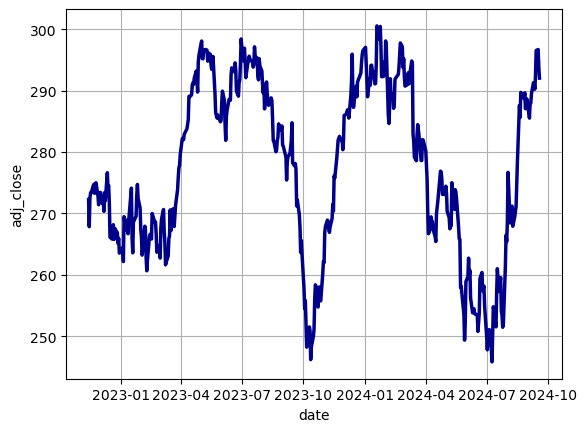

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
metadata = MetaData()

while True:
    engine_name = input("engine name: ")
    if validate_engine_in_directory(engine_name):
        break
        
    # Input the table name you want to query
ticker = input("Enter the table name: ")

y = Get_data(engine_name,ticker)

sns.lineplot(x=y["date"],y=y["adj_close"],color='darkblue', linewidth=2.5)
plt.grid(True)